In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

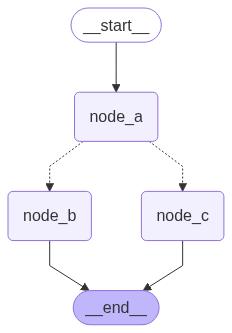

In [29]:
from typing import Literal, TypedDict
from langgraph.graph import StateGraph
from IPython.display import Image, display


class State(TypedDict):
    x: int


def node_a(state: State):
    return {"x": state["x"] + 1}


def node_b(state: State):
    return {"x": state["x"] - 2}


def node_c(state: State):
    return {"x": state["x"] + 1}


def routing_function(state: State) -> Literal["node_b", "node_c"]:
    if state["x"] == 10:
        return "node_b"
    else:
        return "node_c"


builder = StateGraph(State)

builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

builder.set_entry_point("node_a")

# 构建节点之间的边
builder.add_conditional_edges("node_a", routing_function)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

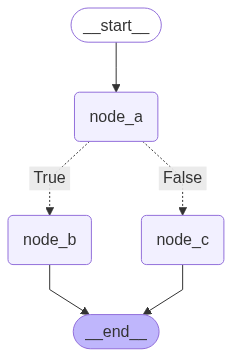

In [31]:
from typing import Literal, TypedDict
from langgraph.graph import StateGraph
from langgraph.graph import StateGraph
from IPython.display import Image, display


class State(TypedDict):
    x: int


def node_a(state: State):
    return {"x": state["x"] + 1}


def node_b(state: State):
    return {"x": state["x"] - 2}


def node_c(state: State):
    return {"x": state["x"] + 1}


def routing_function(state: State):
    if state["x"] == 10:
        return True
    else:
        return False


builder = StateGraph(State)

builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

builder.set_entry_point("node_a")

# 构建节点之间的边
builder.add_conditional_edges(
    "node_a", routing_function, {True: "node_b", False: "node_c"}
)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 结构化输出

In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="qwen-plus")

In [ ]:
# 1. 使用提示工程

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [("system", "Answer the query, Wrap the output in `json`"), ("human", "{query}")]
)

chain = prompt | llm

In [39]:
resp = chain.invoke(
    {"query": "我叫 bo， 今年 100 岁，邮箱地址是 abc@123.com, 电话是 12343441"}
)
print(resp.content)

{
  "name": "bo",
  "age": 100,
  "email": "abc@123.com",
  "phone": "12343441"
}


In [49]:
# 2. 提示工程 + 输出解析器

import json
import re
from langchain_core.messages import AIMessage


def extract_json(message: AIMessage) -> list[dict]:
    text = message.content

    pattern = r"\`\`\`json(.*?)\`\`\`"

    matches = re.findall(pattern, text, re.DOTALL)

    try:
        return [json.loads(match.strip()) for match in matches]
    except Exception:
        raise ValueError(f"Failed to parse: {message}")


chain = prompt | llm | extract_json

In [50]:
resp = chain.invoke(
    {"query": "我叫 bo， 今年 100 岁，邮箱地址是 abc@123.com, 电话是 12343441"}
)
print(resp)

[{'name': 'bo', 'age': 100, 'email': 'abc@123.com', 'phone': '12343441'}]


## 3. LangGraph 内置工具，可用 TypedDict、JSON Schema 或 Pydantic

In [65]:
# 3.1 用 Pydantic

from pydantic import BaseModel, Field
from typing import Optional


class UserInfo(BaseModel):
    """Extracted user information, such as name, age, email, and phone number, if relevant."""

    name: str = Field(description="The name of the user")
    age: Optional[int] = Field(description="The age of the user")
    email: str = Field(description="The email address of the user")
    phone: Optional[str] = Field(description="The phone number of the user")


llm = ChatOpenAI(model="deepseek-v3")

structured_llm = llm.with_structured_output(UserInfo)

In [73]:
resp = llm.invoke(
    "请以json格式回复，不要包含 '```json``` 这样的 markdown 标记。我叫 bo， 今年 100 岁，邮箱地址是 abc@123.com, 电话是 12343441"
)
print(resp.content)

{
  "name": "bo",
  "age": 100,
  "email": "abc@123.com",
  "phone": "12343441"
}


In [69]:
UserInfo.model_validate_json(resp.content)

ValidationError: 1 validation error for UserInfo
  Invalid JSON: expected value at line 1 column 1 [type=json_invalid, input_value='```json\n{\n  "name": "b...ne": "12343441"\n}\n```', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid

In [71]:
resp = structured_llm.invoke(
    "请以json格式回复，不要包含 '```json``` 这样的 markdown 标记。我叫 bo， 今年 100 岁，邮箱地址是 abc@123.com, 电话是 12343441"
)
print(resp)

name='bo' age=100 email='abc@123.com' phone='12343441'


In [72]:
resp

UserInfo(name='bo', age=100, email='abc@123.com', phone='12343441')